## Evaluating JPEG Compression Impact on Adversarial Attacks

This notebook investigates whether saving adversarially perturbed images as JPEGs with different quality levels diminishes the effectiveness of adversarial attacks on a ResNet50 model. Four attacks are considered: FGSM, PGD, DeepFool, and CW. The workflow includes generating adversarial examples, saving them as JPEGs, reloading, and comparing model predictions.

In [1]:
import os

import torch
import torch.utils.data as data
import torchvision.models as models
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from attacks.fgsm import FGSM
from attacks.pgd import PGD
from attacks.cw import CW
from attacks.deepfool import DeepFool

from utils.helpers import preprocess, inv_tensor_transform, set_seed, load_imagenet_classes
from utils.evaluation import evaluate_attack

## Configuration

In [2]:
IMAGENET_VAL_DIR = './data/imagenet_val/'
LABEL_MAP_FILE = './data/imagenet_classes.txt'
os.makedirs('results/jpeg_attacks', exist_ok=True)

BATCH_SIZE = 8 # How many images to process at once
NUM_IMAGES = 32 # How many images to process in total

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 806

# Set random seed for reproducibility
set_seed(SEED, DEVICE)

# Check device
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
if NUM_IMAGES > 1000:
    raise ValueError("NUM_IMAGES must be less than or equal to 1024, the number of images in the dataset.")

## Load model and data

### Load Pre-trained model (ResNet50)

In [4]:
# Load a pre-trained ResNet50 model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model = model.to(DEVICE)
model.eval()

print("ResNet50 model loaded successfully.")

ResNet50 model loaded successfully.


### Load ImageNet subset

In [5]:
# Create a dataset object
imagenet_data = datasets.ImageFolder(IMAGENET_VAL_DIR, preprocess)
print(f"Found {len(imagenet_data)} images in {IMAGENET_VAL_DIR}")
print(f"Class mapping (first 5): {list(imagenet_data.class_to_idx.items())[:5]}")

# Use a subset of the data
subset_indices = list(range(min(NUM_IMAGES, len(imagenet_data))))
imagenet_subset = data.Subset(imagenet_data, subset_indices)

# Create a DataLoader
test_loader = data.DataLoader(imagenet_subset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Created DataLoader with {len(imagenet_subset)} images.")

Found 1000 images in ./data/imagenet_val/
Class mapping (first 5): [('n01440764', 0), ('n01443537', 1), ('n01484850', 2), ('n01491361', 3), ('n01494475', 4)]
Created DataLoader with 32 images.


### Load class labels

In [6]:
imagenet_classes = load_imagenet_classes(LABEL_MAP_FILE)
print(f"Loaded {len(imagenet_classes)} class names from index file.")
print("Sample class names:", list(imagenet_classes.items())[:5])

Loaded 1000 class names from index file.
Sample class names: [(0, 'tench'), (1, 'goldfish'), (2, 'great_white_shark'), (3, 'tiger_shark'), (4, 'hammerhead')]


### Define Fixed Attacks & JPEG Parameters

In [7]:
# FGSM
FGSM_EPSILON = 0.03

# PGD
PGD_EPSILON = 0.03
PGD_ALPHA = 0.007
PGD_STEPS = 10

# CW
CW_C = 1
CW_KAPPA = 0
CW_STEPS = 100
CW_LR = 0.01

# DeepFool
DF_STEPS = 5
DF_OVERSHOOT = 0.02
NUM_CLASSES = 1000

In [8]:
JPEG_QUALITIES = [95, 85, 70]

In [9]:
# Instantiate attacks
attacks = {
    'FGSM': FGSM(model, eps=FGSM_EPSILON, clip_min=None, clip_max=None),
    'PGD': PGD(model, eps=PGD_EPSILON, alpha=PGD_ALPHA, steps=PGD_STEPS, clip_min=None, clip_max=None),
    'CW': CW(model, c=CW_C, kappa=CW_KAPPA, steps=CW_STEPS, lr=CW_LR, clip_min=None, clip_max=None),
    'DeepFool': DeepFool(model, steps=DF_STEPS, overshoot=DF_OVERSHOOT, num_classes=NUM_CLASSES, clip_min=None, clip_max=None)
}

## Perform attacks and save images

In [10]:
all_adv_filepaths = {atk: [] for atk in attacks}
all_adv_images = {atk: [] for atk in attacks}  # Store in-memory adversarial images

for attack_name, attack in attacks.items():
    print(f"Generating adversarial examples for {attack_name}...")
    adv_results, clean_results = evaluate_attack(attack, test_loader, model, DEVICE, NUM_IMAGES)
    adv_images = adv_results['images']
    all_adv_images[attack_name] = adv_images  # Save in-memory images

    for idx, adv_img_tensor in enumerate(adv_images):
        adv_img_pil = inv_tensor_transform(adv_img_tensor)
        base_path = f'results/jpeg_attacks/{attack_name}_{idx}'
        adv_img_pil.save(f'{base_path}_raw.png')
        all_adv_filepaths[attack_name].append({'raw': f'{base_path}_raw.png'})

        for q in JPEG_QUALITIES:
            jpeg_path = f'{base_path}_q{q}.jpg'
            adv_img_pil.save(jpeg_path, quality=q)
            all_adv_filepaths[attack_name][-1][f'jpeg_{q}'] = jpeg_path

print('Saved all perturbed images as JPEGs with different qualities.')

Generating adversarial examples for FGSM...


  Processed 32 images. Stopping.
Attack evaluation finished. Accuracy: 62.50%


Generating adversarial examples for PGD...


  Processed 32 images. Stopping.
Attack evaluation finished. Accuracy: 15.62%


Generating adversarial examples for CW...


  Processed 32 images. Stopping.
Attack evaluation finished. Accuracy: 0.00%


Generating adversarial examples for DeepFool...


  Processed 32 images. Stopping.
Attack evaluation finished. Accuracy: 43.75%


Saved all perturbed images as JPEGs with different qualities.


In [11]:
# Evaluate model predictions on raw perturbed (in-memory) and JPEG images
results = {atk: {'raw': [], 'jpeg_95': [], 'jpeg_85': [], 'jpeg_70': []} for atk in attacks}

for attack_name, filelist in all_adv_filepaths.items():
    # Use stored in-memory adversarial images for 'raw' evaluation
    adv_images = all_adv_images[attack_name]

    # Evaluate in-memory (raw) adversarial images
    for adv_img_tensor in adv_images:
        with torch.no_grad():
            pred_raw = model(adv_img_tensor.unsqueeze(0).to(DEVICE)).argmax(dim=1).item()
        results[attack_name]['raw'].append(pred_raw)

    # Evaluate JPEG-reloaded images
    for idx, filepaths in enumerate(filelist):
        for q in JPEG_QUALITIES:
            img_jpeg = preprocess(Image.open(filepaths[f'jpeg_{q}']))
            with torch.no_grad():
                pred_jpeg = model(img_jpeg.unsqueeze(0).to(DEVICE)).argmax(dim=1).item()
            results[attack_name][f'jpeg_{q}'].append(pred_jpeg)

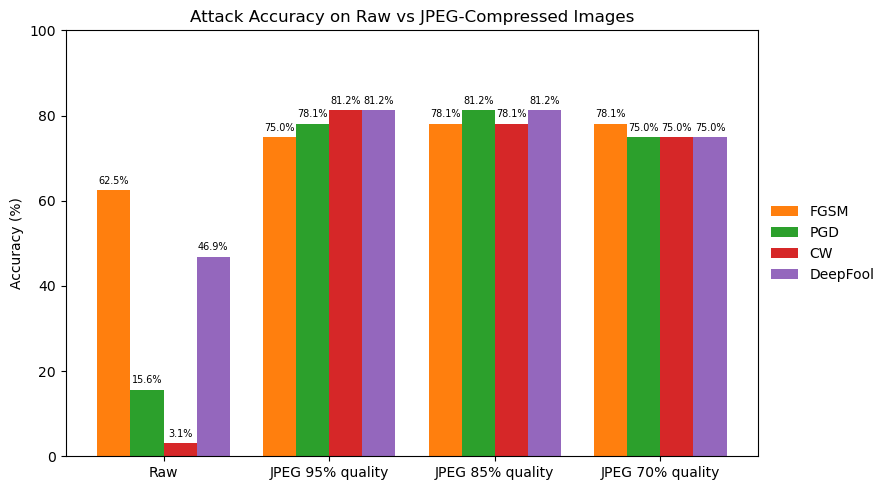

In [12]:
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
formats = ['raw'] + [f'jpeg_{q}' for q in JPEG_QUALITIES]
x_labels = ['Raw'] + [f'JPEG {q}% quality' for q in JPEG_QUALITIES]

acc_matrix = []
for attack_name in attacks:
    accs = []
    for fmt in formats:
        preds = np.array(results[attack_name][fmt])
        true_labels = [label for _, label in list(test_loader.dataset)]
        acc = (preds == np.array(true_labels[:len(preds)])).mean() * 100
        accs.append(acc)
    acc_matrix.append(accs)
acc_matrix = np.array(acc_matrix)

x = np.arange(len(formats))
bar_width = 0.20

plt.figure(figsize=(9, 5))
for i, (attack_name, color) in enumerate(zip(attacks, colors)):
    bars = plt.bar(x + i * bar_width, acc_matrix[i], width=bar_width, label=attack_name, color=color)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

plt.xticks(x + bar_width * (len(attacks) - 1) / 2, x_labels)
plt.ylabel('Accuracy (%)')
plt.title('Attack Accuracy on Raw vs JPEG-Compressed Images')
plt.ylim(0, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.tight_layout()
plt.show()